In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../../../astro_codes/')
#------------------------------------
from luminosities_magnitudes_and_distances import Mag_to_lum

## Load all of the required data:

In [3]:
gz_data = Table.read('../matched_fits/gz_data.fits')
chang_in_matched = Table.read('../matched_fits/chang_in_matched.fits')
chang_out_matched = Table.read('../matched_fits/chang_out_matched.fits')
nsa_matched = Table.read('../matched_fits/nsa_matched.fits')
samples = Table.read('../matched_fits/samples.fits')
print('Loaded all data.')

Loaded all data.


## Create masks to keep:

#### i) M*-limited
#### ii) M*-limited spirals

In [4]:
in_ml = ((samples['in_nsa']) & 
         (samples['in_wise']) &
         (samples['in_mass_limit']))

in_spiral = ((in_ml) & 
             (samples['in_spiral']) &
             (samples['axial_ok']))

print('{} in M*-limited sample'.format(np.sum(in_ml)))
print('w. {} in M*-limited spiral sample'.format(np.sum(in_spiral)))

25759 in M*-limited sample
w. 6343 in M*-limited spiral sample


#### iii) mask out low-SNR fluxes

In [6]:
def print_sample_size(mask,name):
    y = np.sum(mask)
    t = len(mask)
    print(name + ': {}/{} galaxies ({}%)'.format(y,t,np.round(100*y/t,decimals=1)))

w3_ok = chang_out_matched['flag_w3'] == 1
w4_ok = chang_out_matched['flag_w4'] == 1

def snr_mask(column,min_snr=2):
    snr = nsa_matched['PETROFLUX'][:,column]/((nsa_matched['PETROFLUX_IVAR'][:,column])**(-1/2))
    detected = nsa_matched['AMIVAR'][:,column] != 0
    ok = (snr >= min_snr) & (detected)
    return ok

fuv_ok,nuv_ok,u_ok,g_ok,r_ok,i_ok,z_ok = [snr_mask(c) for c in range(7)]

print_sample_size(w3_ok,'W3 detected')
print_sample_size(w4_ok,'W4 detected')
print_sample_size(fuv_ok,'FUV detected')
print_sample_size(nuv_ok,'NUV detected')
print_sample_size(u_ok,'u detected')

mask_bad_fluxes = Table()
mask_bad_fluxes['fuv'] = fuv_ok
mask_bad_fluxes['nuv'] = nuv_ok
mask_bad_fluxes['u'] = u_ok
mask_bad_fluxes['g'] = g_ok
mask_bad_fluxes['r'] = r_ok
mask_bad_fluxes['i'] = i_ok
mask_bad_fluxes['z'] = z_ok
mask_bad_fluxes['w3'] = w3_ok
mask_bad_fluxes['w4'] = w4_ok

W3 detected: 157609/248883 galaxies (63.3%)
W4 detected: 81579/248883 galaxies (32.8%)
FUV detected: 34829/248883 galaxies (14.0%)
NUV detected: 53129/248883 galaxies (21.3%)
u detected: 67871/248883 galaxies (27.3%)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in power
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal


In [68]:
# Now calculate the SFRs:
from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar, wavelength_to_frequency
import astropy.units as u

l_22 = chang_out_matched['lrest_w4']
l_fuv = lum_to_solar(Mag_to_lum(nsa_matched['M_corrected'][:,0],1538.62))

def fuv_sfr(L):
    nu_fuv = wavelength_to_frequency(1538.62*u.Angstrom).value
    L = 10**(L)
    #print(L)
    sfr = 10**(-9.69)*(L.value)
    return np.log10(sfr)
    #return None
def mir_sfr(L):
    L = 10**(L)
    sfr = 0.87*10**(-9.125)*(L)
    return np.log10(sfr)

../../../astro_codes/luminosities_magnitudes_and_distances.py:38: RuntimeWarning: overflow encountered in power
  S = 3631*10**(Mag/-2.5)*u.Jy # AB -> flux density


[ 0.66028281  0.054206   -0.83277444 ..., -4.42822065         inf
 -0.0904313 ]


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


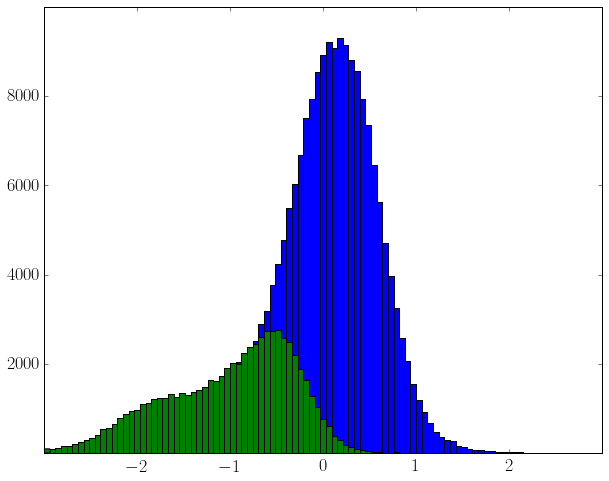

In [77]:
sfr_fuv = fuv_sfr(l_fuv)
sfr_mir = mir_sfr(l_22)
print(sfr)
_ = plt.hist(sfr_mir[np.isfinite(sfr_mir)],bins=np.linspace(-3,3,100))
_ = plt.hist(sfr_fuv[np.isfinite(sfr_fuv)],bins=np.linspace(-3,3,100))

sfrs = Table()
sfrs['fuv'] = sfr_fuv
sfrs['mir'] = sfr_mir
sfrs['total'] = np.log10(10**sfr_fuv + 10**sfr_mir)

## Finally, save the 'bad flux' and 'FUV weights' table for later use.

In [78]:
mask_bad_fluxes.write('../matched_fits/bad_flux_mask.fits',overwrite=True)
sfrs.write('../matched_fits/sfrs.fits',overwrite=True)